In [7]:
import numpy as np
import pandas as pd
import h3
import folium
import json
from folium import plugins
import branca.colormap as cmp

In [8]:
data = pd.read_csv("10_percent_consump.csv").drop("Unnamed: 0", axis=1)
data.head(1)

,Trip Start Timestamp,Trip End Timestamp,Trip Seconds,Trip Miles,Pickup Centroid Latitude,Pickup Centroid Longitude,Dropoff Centroid Latitude,Dropoff Centroid Longitude,max_temp,min_temp,precip,Trip min,consumption_city_kWh,consumption_combined_kWh
0,2019-01-01 00:00:00,01/01/2019 12:00:00 AM,249.0,0.8,41.970245,-87.713435,41.964652,-87.721017,2.8,2.2,1.0,4,0.22472,0.24104


In [9]:
#create hexagons for mapping
#long runtime
hexagons = pd.DataFrame({"geo_json":[],"trips_ended":[],"consumed_kWh_city":[], "consumed_kWh_avg":[]})
for index, row in data.iterrows():
    hex_id = h3.geo_to_h3(
        lat=row["Dropoff Centroid Latitude"],
        lng=row["Dropoff Centroid Longitude"],
        resolution=7
    )
    hex_json = h3.h3_to_geo_boundary(hex_id, geo_json=True)
    #if hexagon is already drawn
    if hex_id in hexagons.index:
        hexagons.at[hex_id, "trips_ended"] += 1
        hexagons.at[hex_id, "consumed_kWh_city"] += row["consumption_city_kWh"]
        hexagons.at[hex_id, "consumed_kWh_avg"] += row["consumption_combined_kWh"]
    else:
        hexagons.loc[hex_id] = [
            {
                "type": "Feature",
                "geometry": {
                    "type": "Polygon",
                    "coordinates": [json.loads(json.dumps(hex_json))]
                }
            },
            1,
            row["consumption_city_kWh"],
            row["consumption_combined_kWh"]
        ]


In [28]:
#plot consumption over chicago map
#add properties
for index, row in hexagons.iterrows():
    row["geo_json"]["properties"] = {
        "ends":row["trips_ended"],
        "accu_city_kWh":row["consumed_kWh_city"],
        "accu_combined_kWh":row["consumed_kWh_avg"]
    }

# OpenStreetMap,Stamen Toner
map = folium.Map(location=(41.873222041337044, -87.62596070777431), tiles='OpenStreetMap', zoom_start=11, control_scale=True, max_zoom=20)

max_value = hexagons["consumed_kWh_city"].max()
print("Max kWh", max_value)
#create colorscale
color_map = cmp.LinearColormap(
 ['blue', "yellow",'red'],
 vmin=0, vmax=np.log10(max_value*10),
 caption='kWh (log10)'    #Caption for Color scale or Legend
)
#paint on map
def style_function(x):
    #r, g ,b = rgb(0, np.log(max_value), np.log(x["properties"]["accu_city_kWh"]))
    return {
        "color":color_map(np.log10(x["properties"]["accu_city_kWh"]*10)),
        "weight":1,
        "opacity":1,
        "fillOpacity": .6
    }
    

for index, row in hexagons.iterrows():
    layer = folium.GeoJson(row["geo_json"],style_function=style_function,tooltip=f'kWh per Year: {row["consumed_kWh_city"]}')
    layer.add_to(map)


#map.fit_bounds(layer.get_bounds())
color_map.add_to(map)

map

Max kWh 2091972.9745982187


In [11]:
#showcase h3 grid
show_map = folium.Map(location=(41.873222041337044, -87.62596070777431), tiles='OpenStreetMap', zoom_start=11, control_scale=True, max_zoom=20)
center_hex_id = h3.geo_to_h3(
        lat=41.873222041337044,
        lng=-87.62596070777431,
        resolution=6
    )
show_case_hexgons = list()
show_case_hexgons.append(
    {
        "type": "Feature",
        "geometry": {
            "type": "Polygon",
            "coordinates": [h3.h3_to_geo_boundary(center_hex_id, geo_json=True)]
        }
    }
)
for value in h3.hex_ring(center_hex_id, k=1):
    show_case_hexgons.append(
        {
            "type": "Feature",
            "geometry": {
                "type": "Polygon",
                "coordinates": [h3.h3_to_geo_boundary(value, geo_json=True)]
            }
        }
    )

for value in show_case_hexgons:
    layer = folium.GeoJson(value)
    layer.add_to(show_map)

#show_map

In [12]:
#create dataset
data_with_hexagons = data.copy()
data_with_hexagons["hex_id"] = data.apply(lambda x:h3.geo_to_h3(
        lat=x["Dropoff Centroid Latitude"],
        lng=x["Dropoff Centroid Longitude"],
        resolution=7
    ),axis=1)
data_with_hexagons.drop(axis=1,labels=["Pickup Centroid Latitude","Pickup Centroid Longitude","Dropoff Centroid Latitude","Dropoff Centroid Longitude"],inplace=True)
data_with_hexagons.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10356323 entries, 0 to 10356322
Data columns (total 11 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   Trip Start Timestamp      object 
 1   Trip End Timestamp        object 
 2   Trip Seconds              float64
 3   Trip Miles                float64
 4   max_temp                  float64
 5   min_temp                  float64
 6   precip                    float64
 7   Trip min                  int64  
 8   consumption_city_kWh      float64
 9   consumption_combined_kWh  float64
 10  hex_id                    object 
dtypes: float64(7), int64(1), object(3)
memory usage: 869.1+ MB


In [13]:
#resample for prediction per h3 cell
list_by_hex_id = pd.Series(dtype=object)
def group_processor(group):
    min_trips = 256
    if(len(group.index) >= min_trips):
        list_by_hex_id[group.iloc[0]["hex_id"]] = group

data_with_hexagons.groupby(by="hex_id").apply(group_processor)

for index, df in list_by_hex_id.iteritems():
    df["Trip Start Timestamp"] = pd.to_datetime(df["Trip Start Timestamp"])
    hourly_data = df[[
        "Trip Start Timestamp",
        "Trip Seconds",
        "max_temp",
        "min_temp",
        "precip",
        "Trip min",
        "consumption_city_kWh",
        "consumption_combined_kWh"
        ]].resample("H",on="Trip Start Timestamp").agg({
            "Trip Seconds":"count",
            "max_temp":"mean",
            "min_temp":"mean",
            "precip":"mean",
            "Trip min":"sum",
            "consumption_city_kWh":"sum",
            "consumption_combined_kWh":"sum"
            })
    hourly_data["hour"] = hourly_data.index.to_series().apply(lambda x:x.hour)
    hourly_data["day"] = hourly_data.index.to_series().apply(lambda x:x.day)
    hourly_data["hex_id"] = hourly_data.index.to_series().apply(lambda x:index)
    hourly_data.rename(columns={"Trip Seconds":"trip_total","Trip min":"Aggretaged total Minutes Usage"},inplace=True)
    hourly_data.dropna(inplace=True)
    list_by_hex_id[index] = hourly_data
#list is a pd.Series with h3 ids as index with hourly dataframes as value
print(len(list_by_hex_id))
list_by_hex_id.iloc[0].head(1)


122


,trip_total,max_temp,min_temp,precip,Aggretaged total Minutes Usage,consumption_city_kWh,consumption_combined_kWh,hour,day,hex_id
Trip Start Timestamp,,,,,,,,,,
2019-01-01 09:00:00,1,0.0,0.0,0.0,15,2.83709,3.04313,9,1,872664191ffffff


In [14]:
#get overall info
all_hex_by_hour = pd.concat(list_by_hex_id.to_list(), ignore_index=True)
all_hex_by_hour.describe()

,trip_total,max_temp,min_temp,precip,Aggretaged total Minutes Usage,consumption_city_kWh,consumption_combined_kWh,hour,day
count,727227.000000,727227.000000,727227.000000,727227.000000,727227.000000,727227.000000,727227.000000,727227.000000,727227.000000
mean,14.239887,9.877864,9.819591,0.101644,227.740026,19.558259,20.978652,12.274216,15.711818
std,37.213859,11.750423,11.750592,0.297985,613.205623,45.832253,49.160761,6.765464,8.796362
min,1.000000,-30.600000,-30.600000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,1.100000,1.100000,0.000000,30.000000,2.977540,3.193780,7.000000,8.000000
50%,4.000000,9.400000,9.400000,0.000000,71.000000,6.994410,7.502370,13.000000,16.000000
75%,11.000000,20.000000,20.000000,0.000000,173.000000,16.264110,17.445270,18.000000,23.000000
max,1350.000000,34.400000,34.400000,1.000000,24336.000000,1367.084120,1466.366840,23.000000,31.000000


In [15]:
#run ml models
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sklearn
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

MSE: 9.522245169260088
MAE: 2.3526490125136945
R^2: 0.024606935942297126


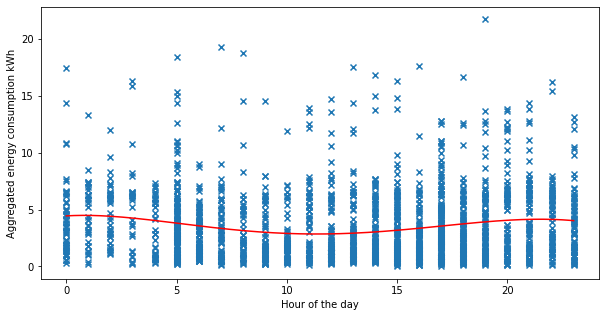

In [16]:
#regresstion overview
def regr(x,y,d):
    #create features
    PF = PolynomialFeatures(degree = d,interaction_only = False, include_bias = True)
    hour_poly = PF.fit_transform(x.reshape(-1,1))
    # create regression
    regression = LinearRegression()
    #normalize values
    regression.fit(hour_poly,y)
    #create curve
    reg_line_points = np.linspace(min(x),max(x),400)
    trans_curve = PF.fit_transform(reg_line_points.reshape(-1,1))
    reg_curve = regression.predict(trans_curve)

    plt.plot(reg_line_points,reg_curve,color="red")
    plt.scatter(x,y,marker="x")
    plt.xlabel("Hour of the day")
    plt.ylabel("Aggregated energy consumption kWh")
    print("MSE: "+ str(mean_squared_error(y,regression.predict(hour_poly))))
    print("MAE: "+ str(mean_absolute_error(y,regression.predict(hour_poly))))
    print("R^2: "+ str(r2_score(y,regression.predict(hour_poly))))

chosen_df = list_by_hex_id.iloc[0]
plt.figure(figsize=(10, 5))
regr(chosen_df["hour"].values,chosen_df["consumption_city_kWh"].values,5)

In [17]:
#add features and run models
# long runtime
results = pd.DataFrame({"hex_id":[],"hour_data_count":[],"score":[]})
for hex_id, df in list_by_hex_id.iteritems():
    if len(df.index) < 2000 : continue
    pred_df = df.copy()
    #add features
    #add weekend/day feature
    pred_df["weekday"] = pred_df.index.to_series().apply(lambda x:0 if x.dayofweek in [5,6] else 1)
    #add daytime feature
    #pred_df["night"] = pred_df.index.to_series().apply(lambda x:1 if x.hour < 6 else 0)
    #pred_df["noon"] = pred_df.index.to_series().apply(lambda x:1 if x.hour >= 6 and x.hour < 12 else 0)
    #pred_df["afternoon"] = pred_df.index.to_series().apply(lambda x:1 if x.hour >= 12 and x.hour < 18 else 0)
    #pred_df["evening"] = pred_df.index.to_series().apply(lambda x:1 if x.hour >= 18 and x.hour < 24 else 0)
    #add season feature
    #pred_df["winter"] = pred_df.index.to_series().apply(lambda x:1 if x.month < 3 or x.month > 11 else 0)
    #pred_df["spring"] = pred_df.index.to_series().apply(lambda x:1 if x.month >= 3 and x.month < 6 else 0)
    #pred_df["summer"] = pred_df.index.to_series().apply(lambda x:1 if x.month >= 6 and x.month < 9 else 0)
    #pred_df["fall"] = pred_df.index.to_series().apply(lambda x:1 if x.month >= 9 and x.month < 12 else 0)
    #add day of week feature
    pred_df["day_of_week"] = pred_df.index.to_series().apply(lambda x:x.dayofweek)

    featured_data = pred_df[[
        "max_temp",
        "min_temp",
        "precip",
        "hour",
        "weekday",
        "day_of_week",
        #"night",
        #"noon",
        #"afternoon",
        #"evening",
        #"winter",
        #"spring",
        #"summer",
        #"fall"
        ]]
    X_train, X_test, y_train, y_test = train_test_split(featured_data, pred_df["consumption_city_kWh"],test_size=0.3, random_state=1)
    sc=StandardScaler()
    X_train_scaled = sc.fit_transform(X_train)
    X_test_scaled = sc.fit_transform(X_test)
    regr = MLPRegressor(hidden_layer_sizes = (100, 50, 30), random_state=1, max_iter=600, learning_rate="constant",solver="adam",activation="relu",alpha=0.05)
    regr = regr.fit(X_train_scaled, y_train)
    results = pd.concat([results, pd.DataFrame({"hex_id":[hex_id],"hour_data_count":[len(pred_df.index)],"score":[regr.score(X_test_scaled, y_test)]})],ignore_index=True)
results.head(3)

,hex_id,hour_data_count,score
0,872664196ffffff,5780.0,-0.028271
1,8726641b2ffffff,3184.0,-0.001055
2,872664520ffffff,8158.0,0.519735


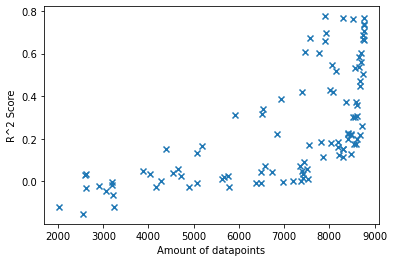

In [18]:
#assess effectiveness of models
plt.scatter(results["hour_data_count"], results["score"], marker="x")
plt.ylabel("R^2 Score")
plt.xlabel("Amount of datapoints")
plt.show()

In [19]:
#create df with geo_json, ignore r2 < 0
pred_hexagons = pd.DataFrame({"geo_json":[],"score":[]})
for index, row in results.iterrows():
    if row["score"] < 0 : continue
    hex_json = h3.h3_to_geo_boundary(row["hex_id"], geo_json=True)
    #if hexagon is already drawn
    pred_hexagons.loc[row["hex_id"]] = [
        {
            "type": "Feature",
            "geometry": {
                "type": "Polygon",
                "coordinates": [json.loads(json.dumps(hex_json))]
            },
            "properties":{
                "score":row["score"],
                "rows":row["hour_data_count"]
            }
        },
        row["score"]
    ]
pred_hexagons.head(2)

,geo_json,score
872664520ffffff,"{'type': 'Feature', 'geometry': {'type': 'Poly...",0.519735
872664521ffffff,"{'type': 'Feature', 'geometry': {'type': 'Poly...",0.546487


In [20]:
#show predictions on map
# OpenStreetMap,Stamen Toner
pred_map = folium.Map(location=(41.873222041337044, -87.62596070777431), tiles='OpenStreetMap', zoom_start=11, control_scale=True, max_zoom=20)

max_pred = pred_hexagons["score"].max()
min_pred = pred_hexagons["score"].min()

print("Max kWh", max_pred)
#create colorscale
pred_color_map = cmp.LinearColormap(
 ['blue', "yellow",'red'],
 vmin=0, vmax=max_pred,
 caption='Score'    #Caption for Color scale or Legend
)
def pred_style_function(x):
    return {
        "color":pred_color_map(x["properties"]["score"]),
        "weight":1,
        "opacity":1,
        "fillOpacity": .6
    }

for index, row in pred_hexagons.iterrows():
    layer = folium.GeoJson(row["geo_json"],style_function=pred_style_function,tooltip=f'Score: {row["score"]}')
    layer.add_to(pred_map)

pred_color_map.add_to(pred_map)

pred_map

Max kWh 0.7751973439046879
